In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# read data
data = pd.read_csv("alzheimers_disease_data.csv")
data.shape

data.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

In [21]:
data.shape

(2149, 33)

## undersampling

In [23]:
from sklearn.utils import resample

class_counts = data.iloc[:, -1].value_counts(normalize=True) * 100
print("Original Class Distribution:\n", class_counts)

# Splitting features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Separate majority and minority classes
majority_class = data[y == 0]  # Non-Alzheimer's (64.6%)
minority_class = data[y == 1]  # Alzheimer's (35.4%)

# Undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, 
                                replace=False,  # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)

# Combine the downsampled majority class with the original minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
new_class_counts = balanced_data.iloc[:, -1].value_counts(normalize=True) * 100
print("Balanced Class Distribution:\n", new_class_counts)

Original Class Distribution:
 Diagnosis
0    64.634714
1    35.365286
Name: proportion, dtype: float64
Balanced Class Distribution:
 Diagnosis
0    50.0
1    50.0
Name: proportion, dtype: float64


In [25]:
balanced_data.shape

(1520, 33)

### encode

In [35]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Step 1: Select the nominal categorical features
nominal_features = ['Ethnicity', 'EducationLevel']

# Step 2: Initialize One-Hot Encoder without dropping any category
ohe = OneHotEncoder(drop=None, sparse_output=False)  # Keep all categories

# Step 3: Fit and transform the categorical features
encoded_features = ohe.fit_transform(balanced_data[nominal_features])

# Step 4: Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(nominal_features))

# Step 5: Drop the original categorical columns and merge encoded features
data = balanced_data.drop(columns=nominal_features).reset_index(drop=True)  # Drop original categorical columns
data = pd.concat([data, encoded_df], axis=1)  # Merge encoded data

# Step 6: Verify the transformed data
print("Updated Dataset After One-Hot Encoding:")
print(data.head())


Updated Dataset After One-Hot Encoding:
   Age  Gender        BMI  Smoking  AlcoholConsumption  PhysicalActivity  \
0   80       1  16.834968        0           19.053565          4.352272   
1   88       1  35.353244        1            0.768943          8.883326   
2   63       0  32.726550        0           16.971929          8.569751   
3   75       1  38.668960        1            6.669039          7.328895   
4   72       0  30.646711        0            4.452856          0.768016   

   DietQuality  SleepQuality  FamilyHistoryAlzheimers  CardiovascularDisease  \
0     3.432055      7.361459                        0                      0   
1     4.085773      7.450835                        0                      0   
2     8.744619      9.227229                        0                      0   
3     7.973275      9.966551                        0                      0   
4     4.978013      7.715735                        0                      1   

   ...  Forgetfulness 

In [47]:
x = data.drop('Diagnosis', axis=1).copy()


In [39]:
x.shape

(1520, 38)

In [41]:
data.shape

(1520, 39)

# Feature selection 

### Spearman correlation


Top 20 Features Based on Spearman Correlation:
                      Feature  Spearman_Correlation       P_value
37           EducationLevel_3              1.000000  0.000000e+00
35           EducationLevel_1             -0.264244  1.061993e-25
36           EducationLevel_2             -0.214208  3.101862e-17
34           EducationLevel_0             -0.167966  4.398676e-11
11                 Depression              0.061484  1.651205e-02
17             CholesterolLDL              0.053344  3.757234e-02
23         BehavioralProblems             -0.044910  8.005496e-02
16           CholesterolTotal             -0.044552  8.249198e-02
26             Disorientation             -0.034726  1.760084e-01
5            PhysicalActivity             -0.030237  2.387379e-01
7                SleepQuality              0.029866  2.445409e-01
6                 DietQuality              0.029182  2.555315e-01
0                         Age             -0.028051  2.744238e-01
28  DifficultyCompletingTask

C:\Users\chapp\AppData\Local\Temp\ipykernel_26276\1427545118.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='Spearman_Correlation', y='Feature', orient='h', palette='coolwarm')


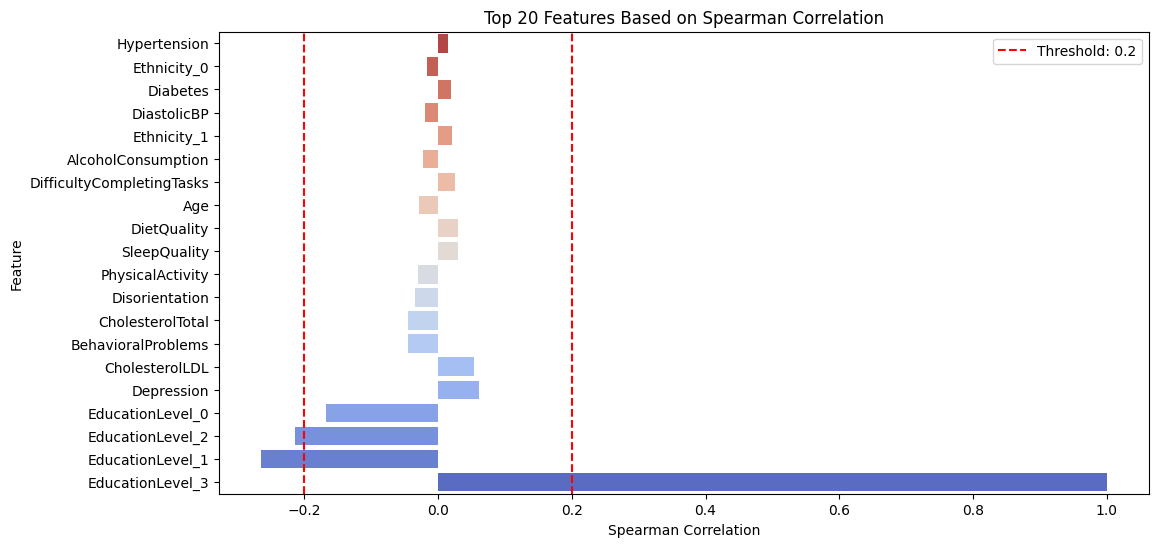

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Step 1: Compute Spearman Correlation for All Features
spearman_results = []

for col in x.columns:  # X contains both numerical and encoded categorical features
    rho, p_value = spearmanr(x[col], y)  # Compute Spearman's correlation
    spearman_results.append((col, rho, p_value))

# Step 2: Convert Results to a DataFrame
spearman_df = pd.DataFrame(spearman_results, columns=['Feature', 'Spearman_Correlation', 'P_value'])

# Step 3: Sort Features by Absolute Spearman Correlation (Descending)
spearman_df['Abs_Spearman'] = spearman_df['Spearman_Correlation'].abs()  # Get absolute values
spearman_df = spearman_df.sort_values(by='Abs_Spearman', ascending=False)  # Sort by importance

# Step 4: Select the Top 20 Features
top_20_features = spearman_df.head(20)

# Step 5: Print Top 20 Features
print("\nTop 20 Features Based on Spearman Correlation:")
print(top_20_features[['Feature', 'Spearman_Correlation', 'P_value']])

# Step 6: Visualize the Top 20 Features
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_features, x='Spearman_Correlation', y='Feature', orient='h', palette='coolwarm')
plt.axvline(0.2, color='red', linestyle='--', label='Threshold: 0.2')
plt.axvline(-0.2, color='red', linestyle='--')
plt.title('Top 20 Features Based on Spearman Correlation')
plt.xlabel('Spearman Correlation')
plt.ylabel('Feature')
plt.legend()
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.show()

### MI

Top 20 Features by Mutual Information Score:
                 Feature  MI Score
21  FunctionalAssessment  0.095454
24                   ADL  0.076564
20                  MMSE  0.066278
22      MemoryComplaints  0.050898
23    BehavioralProblems  0.029937
4     AlcoholConsumption  0.017780
18        CholesterolHDL  0.017349
32           Ethnicity_2  0.012527
30           Ethnicity_0  0.009790
7           SleepQuality  0.009691
27    PersonalityChanges  0.008789
5       PhysicalActivity  0.007947
15           DiastolicBP  0.007522
29         Forgetfulness  0.006378
11            Depression  0.004770
0                    Age  0.003826
33           Ethnicity_3  0.003214
37      EducationLevel_3  0.002929
26        Disorientation  0.001577
1                 Gender  0.001368


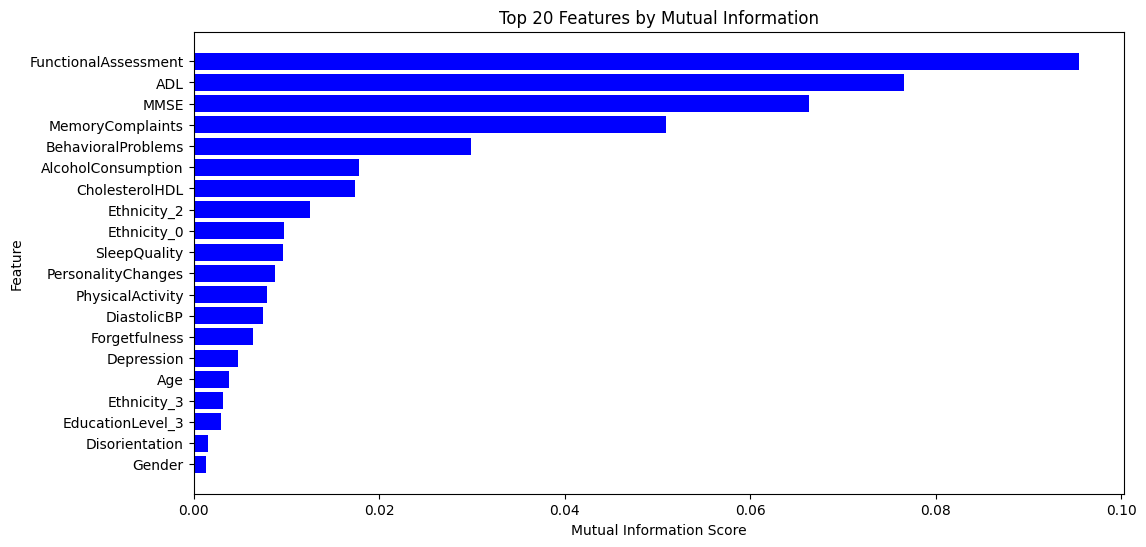

In [47]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(x, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({'Feature': x.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)  # Sort by importance

print("Top 20 Features by Mutual Information Score:")
print(mi_df.head(20))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(mi_df['Feature'][:20], mi_df['MI Score'][:20], color='blue')
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()  # Highest MI at the top
plt.show()


In [57]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA(n_components=20)
pca_data = pca.fit_transform(data)

# Capture the importance of each feature in the principal components
pca_feature_importance = pd.DataFrame(
    pca.components_, 
    columns = data.columns, 
    index=[f'PC{i+1}' for i in range(pca.n_components)]
)

# Print PCA explained variance ratio
print("Explained Variance Ratio of Principal Components:")
print(pca.explained_variance_ratio_)

# Print the most important features for each principal component
print("\nTop Contributing Features for Each Principal Component:")
print(pca_feature_importance.abs().idxmax(axis=1))

Explained Variance Ratio of Principal Components:
[6.54613957e-01 1.18708058e-01 1.13644427e-01 4.22974693e-02
 3.36227698e-02 1.94668460e-02 5.09113073e-03 4.66049716e-03
 3.26673527e-03 2.07998646e-03 5.71411542e-04 5.30860590e-04
 5.12958246e-04 5.02937958e-04 1.93749978e-04 2.22150771e-05
 2.12482991e-05 1.58488010e-05 1.49051621e-05 1.44996226e-05]

Top Contributing Features for Each Principal Component:
PC1     CholesterolTriglycerides
PC2               CholesterolLDL
PC3             CholesterolTotal
PC4                   SystolicBP
PC5               CholesterolHDL
PC6                  DiastolicBP
PC7                          Age
PC8                         MMSE
PC9                          BMI
PC10          AlcoholConsumption
PC11                         ADL
PC12                 DietQuality
PC13            PhysicalActivity
PC14        FunctionalAssessment
PC15                SleepQuality
PC16            EducationLevel_1
PC17                 Ethnicity_0
PC18                      